<a href="https://colab.research.google.com/github/Sobiii/Search-Engine-Design-G4/blob/Sobii/Sobs_Merged_Evaulation_cont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Loading and Extraction**

The section below extracts the 3 files from the CISI data collection:
- CISI.ALL: containing information about the documents.
- CISI.QRY: containing a list of queries to be executed against our retrieval system.
- CISI.REL: contains appropriate relevance assessments to be used in the evaluation of our models.


##### Loading the files

In [1]:
import os as os
import re

# gets the current working directory
directory = os.getcwd()

# defines paths to CISI dataset files
cisi_all_path = os.path.join(directory, 'CISI.ALL')
cisi_qry_path = os.path.join(directory, 'CISI.QRY')
cisi_rel_path = os.path.join(directory, 'CISI.REL')

##### CISI.ALL Extraction

In [2]:
# function extracting text in the CISI.ALL file line by line and populating id, title, author, abstract and publication information fields
def all_extraction(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    doc_ids = []
    documents = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            doc_id = file_lines[i].split()[1]
            doc_ids.append(doc_id)
            if file_lines[i+1].startswith(".T") and file_lines[i+3].startswith(".A"):
                title = file_lines[i+2][:].strip()
            else:
                title = file_lines[i+2].strip() + " " + file_lines[i+3].strip()
            authors = ""
            if any([line.startswith(".A") for line in file_lines[i+1:]]):
                author_start = i+4
                author_end = author_start
                while author_end < len(file_lines) and not any([file_lines[author_end].startswith(tag) for tag in [".T", ".B", ".W", ".Y"]]):
                    author_end += 1
                authors = " ".join([file_lines[j].strip() for j in range(author_start, author_end)]).strip()
                authors = re.sub(r"^\s*\.\s*A\s*", "", authors)
                abstract_start = author_end
            else:
                abstract_start = i+4

            for t in range(i+4, len(file_lines)):
                if file_lines[t].startswith(".X"):
                    abstract_end = t
                    break
            else:
                abstract_end = len(file_lines)
            abstract = " ".join(file_lines[abstract_start:abstract_end]).strip().replace('\n', ' ')
            abstract = re.sub(r"^\s*\.\s*W\s*", "", abstract)
            abstract = " ".join(abstract.split())
            source = re.search(r"\.B\s+(.*)\.W", abstract)
            if source:
                source = source.group(1)
                source = re.sub(r"^\s*\.\s*A\s*", "", source)
                source = re.sub(r"^\s*\.\s*B\s*", "", source)
            else:
                source = ""
            abstract = re.sub(r"^\s*\.\s*B\s*(.*)\.W", "", abstract)
            abstract = " ".join(abstract.split())
            year = re.search(r"\.Y\s+(\d{4})", abstract)
            if year:
                year = int(year.group(1))
            else:
                year = ""
            abstract = re.sub(r"^\s*\.\s*Y\s*\d{4}\s*", "", abstract)
            abstract = " ".join(abstract.split())
            documents.append({"document_id": doc_id, "title": title, "authors": authors, "abstract": abstract, "source": source, "year": year})
            i = abstract_end
        else:
            i += 1

    return documents

In [3]:
documents = all_extraction(cisi_all_path)
#documents

##### CISI.QRY Extraction

In [7]:
# query extraction from CISI.QRY file (1st 57 queries only)
def extraction_query(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries_1 = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                break
            if file_lines[i+1].startswith(".W"):
                query_text = file_lines[i+2].strip()
                for t in range(i+3, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    query_text += " " + file_lines[t].strip()
            else:
                query_text = ""
            queries_1.append({"query_id": query_id, "query_text": query_text})
        i += 1

    return queries_1
     

In [8]:
# query extraction from CISI.QRY file (58th query onwards)
def extraction_remaining_queries(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                query_title = ""
                query_author = ""
                query_text = ""
                query_source = ""
                found_text_field = False
                found_source_field = False
                for t in range(i+1, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    elif file_lines[t].startswith(".T"):
                        query_title += file_lines[t][3:].strip()
                        # Check if the next line starts with .A and the line after that starts with .T
                        next_t = t+1
                        if next_t < len(file_lines) and file_lines[next_t].startswith(".A") and (next_t+1) < len(file_lines) and file_lines[next_t+1].startswith(".T"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                        # Check if the next line also contains title text
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".A") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".A"):
                        query_author += file_lines[t+1][3:].strip()
                        # Check if the next line also contains author text
                        next_t = t+1
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".T") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B") and not file_lines[next_t].startswith(".A"):
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".W"):
                        found_text_field = True
                        query_text = re.sub(r'^\.W\s*', '', file_lines[t].strip())  # Use regex to remove ".W" tag from the beginning of the line
                        for u in range(t+2, len(file_lines)):
                            if file_lines[u].startswith(".I") or file_lines[u].startswith(".B"):
                                break
                            query_text += " " + file_lines[u].strip()
                    elif file_lines[t].startswith(".B"):
                        found_source_field = True
                        query_source = file_lines[t][3:].strip()
                        for u in range(t+1, len(file_lines)):
                            if file_lines[u].startswith(".I"):
                                break
                            query_source += " " + file_lines[u].strip()
                    elif not found_text_field and not found_source_field:
                        # Assume any field that appears before the .W and .B field is either the title or author
                        if not query_title:
                            query_title = file_lines[t].strip()
                        elif query_author:
                            query_author = file_lines[t-1].strip()
                            query_author += file_lines[t].strip()
                queries.append({"query_id": query_id, "query_title": query_title, "query_author": query_author, "query_text": query_text, "query_source": query_source})
        i += 1

    return queries

In [9]:
# joining all queries into one set
queries_1 = extraction_query(cisi_qry_path)
queries_2 = extraction_remaining_queries(cisi_qry_path)
queries_all = queries_1 + queries_2

##### CISI.REL Extraction

In [10]:
import pandas as pd
rel_df = pd.read_csv('CISI.REL', names=['query_id', 'document_id', 'relevance', 'score'], delimiter='\s+')
rel_df = rel_df.drop(columns=['relevance', 'score'])
print(rel_df.isnull().values.any()) # checking for any NaN values or errors in the extraction
rel_df.head()

False


,query_id,document_id
0,1,28
1,1,35
2,1,38
3,1,42
4,1,43


In [11]:
# converting dataframe into a dictionary using query id as key and document ids as values
query_ids = rel_df['query_id'].unique()
rel_dict = {}

for query_id in query_ids:
    documents1 = rel_df[rel_df['query_id'] == query_id]['document_id'].tolist()
    rel_dict[query_id] = documents1

# converting our dictionary into a list for easier visualisation
rel_list = [(k, v) for k, v in rel_dict.items()]

In [252]:
# reformatting 'rel_list' for easier visualisation
relevant_documents = [(query_id, document_ids) for query_id, document_ids in rel_list]
relevant_documents = [{'query_id': query_id, 'relevant_document_ids': document_ids} for query_id, document_ids in rel_list]
# relevant_documents[2] # print out the first query and its top 10 results just to see the formatting

# **Preprocessing the Data**

#### Corpus creation

In [13]:
# Importing NLP preprocessing libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Creating corpus
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

corpus = []

for document in documents:
    text = ""
    if "title" in document and document["title"]:
        text += document["title"]
    if "authors" in document and document["authors"]:
        text += " " + document["authors"]
    if "abstract" in document and document["abstract"]:
        text += " " + document["abstract"]
    if text:  # only add non-empty strings to corpus
        # Remove special characters, numbers, and punctuation marks
        text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
        # Remove quotation marks
        text = text.replace("'", "").replace('"', '')
        # Tokenize and convert to lowercase
        tokens = word_tokenize(text.lower())
        # Remove stop words
        filtered_text = [word for word in tokens if word not in stop_words]
        # Lemmatize words
        lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
        # Join tokens back to form a string
        preprocessed_text = ' '.join(lemmatized_text)
        corpus.append(preprocessed_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Printing the 3rd document from corpus to check against CISI.ALL file
print(corpus[2])

two kind power essay bibliographic control wilson p relationship organization control writing organization control knowledge information inevitably enter story writing contain along much else great deal mankind stock knowledge information bibliographical control form power knowledge form power familiar slogan claim bibliographical control certain sense power power power obtain knowledge recorded written form writing simply simple way storehouse knowledge satisfactorily discus bibliographical control simply control knowledge information contained writing


### Preprocessing queries

In [42]:
# Preprocessing queries
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_queries_all = []

for query in queries_all:
    query_text = query['query_text']  # Extract query_text from the dictionary
    # Tokenize and convert to lowercase
    tokens = word_tokenize(query_text.lower())
    # Remove special characters, numbers, and punctuation marks
    filtered_query = [word for word in tokens if word not in string.punctuation + string.digits]
    # Remove quotation marks
    filtered_query = [word.replace("'", "").replace('"', '') for word in filtered_query]
    # Remove stop words
    filtered_query = [word for word in filtered_query if word not in stop_words]
    # Lemmatize words
    lemmatized_query = [lemmatizer.lemmatize(word) for word in filtered_query]
    # Join tokens back to form a string
    preprocessed_query = ' '.join(lemmatized_query)
    preprocessed_queries_all.append(preprocessed_query)
    qry_terms_all = preprocessed_queries_all

In [43]:
# Printing example queries
qry_terms_all[2]

'information science give definition possible'

# **Indexing**

In [255]:
# loading in appropriate packages
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# creating TFIDF matrix for our corpus
vectorizer = TfidfVectorizer(stop_words='english')
documents_vectorized = vectorizer.fit_transform(corpus)

print('We have a {} document corpus with a {} term vocabulary'.format(*documents_vectorized.shape))

We have a 1460 document corpus with a 10290 term vocabulary


**NOTE - the TFIDF matrices for the documents and queries are created within the VSM implementation. This way, changes made to the preprocessing of the corpus or queries only require re-running the implementation steps.**

# **VSM Implementation**

In [256]:
# function to automatically generate TFIDF matrices and return a list of the top 10 results for each query
def VSM(corpus, queries, num_results):
    # Step 1-4: Preprocess corpus and create document-term frequency matrix and fit TfidfTransformer to it
    vectorizer = CountVectorizer()
    term_matrix = vectorizer.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(term_matrix)

    # Initialize list to store query-document tuples
    results = []

    # Step 5-9: Loop through queries, calculate cosine similarity, and print top matching documents for each query
    for query_id, query in enumerate(queries):
        # Step 5: Convert the query into a term frequency matrix using the vocabulary from the CountVectorizer used to create tfidf_matrix
        query_matrix = vectorizer.transform([query])

        # Step 6: Transform the query-term frequency matrix into a TF-IDF matrix using the TfidfTransformer fitted to the document-term frequency matrix
        query_tfidf = tfidf_transformer.transform(query_matrix)

        # Step 7: Calculate cosine similarity between query TF-IDF matrix and document TF-IDF matrix
        cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()

        # Step 8: Get indices of documents with highest similarity scores
        top_indices = cosine_similarities.argsort()[::-1][:num_results]

        # Step 9: Append query-document tuple to list
        results.append((query_id+1, [index+1 for index in top_indices]))

        # Print top matching documents
        print(f"Top {num_results} matching documents for query '{query}':")
        for i, index in enumerate(top_indices):
            print(f"Rank {i+1}: {documents[index]}")
        print()
    return results

In [257]:
results = VSM(corpus, qry_terms_all, 10) # executes all queries against the search engine

Top 10 matching documents for query 'problem concern making descriptive title difficulty involved automatically retrieving article approximate title usual relevance content article title':
Rank 1: {'document_id': '722', 'title': 'Information Transfer Limitations of Titles of Chemical Documents', 'authors': 'Bottle, R.R. Seeley, C.R.', 'abstract': 'Some methods of estimating the minimum amounts of information in a document not retrievable through its title are discussed. An analysis of the information transferred by different types of keywords is helpful in planning search strategies, e.g., 30% of chemical substances mentioned in journal articles are not discernable in their titles even when broad class names are used as synonyms. Patents have considerably less informative titles than journal articles. In nuclear science, report titles are also less informative than those of journal articles, but the proportion of reports with completely uninformative titles is now only 10% of the 1957 

In [262]:
retrieved_documents = [(query_id, document_ids) for query_id, document_ids in results]
retrieved_documents = [{'query_id': query_id, 'retrieved_document_ids': document_ids} for query_id, document_ids in results]
retrieved_documents[4] # print out the first query and its top 10 results just to see the formatting

{'query_id': 5,
 'retrieved_document_ids': [1105,
  1166,
  656,
  122,
  1038,
  535,
  648,
  1136,
  1103,
  630]}

In [261]:
relevant_documents[4] # from the cisi.rel file - put here to compare

{'query_id': 5,
 'relevant_document_ids': [32,
  56,
  65,
  114,
  124,
  137,
  187,
  188,
  191,
  241,
  339,
  370,
  400,
  451,
  453,
  471,
  525,
  528,
  642,
  648,
  692,
  1035,
  1246,
  1356]}

# BM25 Implementation

In [263]:
# BM25 Implementation
import numpy as np


def calculate_bm25_score( k1, k2, k3, b, term_weights):

    vocabulary = vectorizer.get_feature_names_out()
    df = pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)
    doc_ids = df.index.values
    
    # Calculate DF
    dfs = (df > 0).sum(axis=0)
    
    # Calculate IDFs
    N = len(df)
    idfs = np.log10(N/dfs)
    
    # Calculate average document length
    dls = df.sum(axis=1).tolist()
    avgdl = np.mean(dls)
    
    # Calculate BM25 score
    numerator = np.array((k1 + 1) * df)
    denominator = np.array(k1 * ((1 - b) + b * (dls / avgdl))).reshape(N, 1) + np.array(df)
    BM25_tf = numerator / denominator
    idfs = np.array(idfs)
    BM25_score = (idfs * BM25_tf * term_weights) + ((k2 + 1) * term_weights * df) / ((k2 * (1 - b + b * (dls / avgdl))).reshape(N, 1) + df) + (k3 * term_weights)
    
    # Convert BM25 score to a pandas DataFrame with matching index and column names
    BM25_score = pd.DataFrame(BM25_score, columns=df.columns, index=df.index)
    
    return BM25_score


### Creating Dataframe of BM25 scores

In [282]:
# Instance of BM25 for CISI documents
bm25_scores = calculate_bm25_score( k1=2.5, k2=0.5, k3=3, b=0.2, term_weights=0.8)
bm25_scores.head() #  not empty just sparse

AttributeError: ignored

In [ ]:
def retrieve_ranking(query, bm25_scores):
    q_terms = query.split(' ')
    common_terms = list(set(q_terms) & set(bm25_scores.columns))
    q_terms_only = bm25_scores[common_terms]
    score_q_d = q_terms_only.sum(axis=1)
    return sorted(zip(bm25_scores.index.values, score_q_d.values),
                  key=lambda tup: tup[1],
                  reverse=True)

def run_bm25_per_query(qry_terms_all, bm25_scores):
    results_df = pd.DataFrame(columns=["QueryID", "DocumentID", "BM25Score"])

    for i, query in enumerate(qry_terms_all, start=1):
        ranking = retrieve_ranking(query, bm25_scores)
        query_results_df = pd.DataFrame(ranking, columns=["DocumentID", "BM25Score"])
        query_results_df["QueryID"] = i
        query_results_df.sort_values("BM25Score", ascending=False, inplace=True) # Sort BM25 scores in descending order
        results_df = pd.concat([results_df, query_results_df], ignore_index=True)

    return results_df

results_df = run_bm25_per_query(preprocessed_queries_all, bm25_scores)
results_df


In [283]:
# BM25 relevant documents list

grouped_results = results_df.groupby("QueryID")
top_10_documents = grouped_results.head(10)


BM25_relevant = top_10_documents.loc[:, ["QueryID", "DocumentID"]]
BM25_relevant_docs = []

for query_id, query_group in BM25_relevant.groupby("QueryID"):
    query_dict = {}
    query_dict["query_id"] = query_id
    query_dict["retrieved_document_ids"] = query_group["DocumentID"].tolist()[:10]
    BM25_relevant_docs.append(query_dict)
BM25_relevant_docs[4]

{'query_id': 5,
 'retrieved_document_ids': [1165,
  1104,
  655,
  121,
  647,
  1037,
  136,
  894,
  534,
  322]}

In [284]:
relevant_documents[4]

{'query_id': 5,
 'relevant_document_ids': [32,
  56,
  65,
  114,
  124,
  137,
  187,
  188,
  191,
  241,
  339,
  370,
  400,
  451,
  453,
  471,
  525,
  528,
  642,
  648,
  692,
  1035,
  1246,
  1356]}

# **Evaluation**

**VSM Evaluation**

In [285]:
# for some reason, not all queries have relevance assessments
# we need to remove those that dont to calculate precision/recall
relevant_query_ids = [rd['query_id'] for rd in relevant_documents]
rel_retrieved_documents = [rd for rd in retrieved_documents if rd['query_id'] in relevant_query_ids]

In [286]:
rel_retrieved_documents[3]
# look at the difference between 'retrieved_documents[34] and 'rel_retrieved_documents[34]!!
# there are no relevance assessments for document 36!

{'query_id': 4,
 'retrieved_document_ids': [790,
  1280,
  179,
  746,
  175,
  565,
  601,
  1224,
  527,
  320]}

In [287]:
print('The number of queries that have relevance assessments is', len(rel_retrieved_documents))

The number of queries that have relevance assessments is 76


In [288]:
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # Get the corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # Calculate precision
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set)

    # Print the precision for the query
    print(f"Query {i+1} Precision: {precision}")


Query 1 Precision: 0.8
Query 2 Precision: 0.0
Query 3 Precision: 0.8
Query 4 Precision: 0.1
Query 5 Precision: 0.1
Query 6 Precision: 0.0
Query 7 Precision: 0.1
Query 8 Precision: 0.0
Query 9 Precision: 0.4
Query 10 Precision: 0.4
Query 11 Precision: 0.4
Query 12 Precision: 0.3
Query 13 Precision: 0.3
Query 14 Precision: 0.0
Query 15 Precision: 0.3
Query 16 Precision: 0.1
Query 17 Precision: 0.1
Query 18 Precision: 0.3
Query 19 Precision: 0.7
Query 20 Precision: 0.3
Query 21 Precision: 0.0
Query 22 Precision: 0.0
Query 23 Precision: 0.2
Query 24 Precision: 0.5
Query 25 Precision: 0.3
Query 26 Precision: 0.7
Query 27 Precision: 0.2
Query 28 Precision: 0.6
Query 29 Precision: 0.3
Query 30 Precision: 0.7
Query 31 Precision: 0.2
Query 32 Precision: 0.3
Query 33 Precision: 0.1
Query 34 Precision: 0.4
Query 35 Precision: 0.3
Query 36 Precision: 0.1
Query 37 Precision: 0.2
Query 38 Precision: 0.3
Query 39 Precision: 0.2
Query 40 Precision: 0.0
Query 41 Precision: 0.6
Query 42 Precision: 0.3
Q

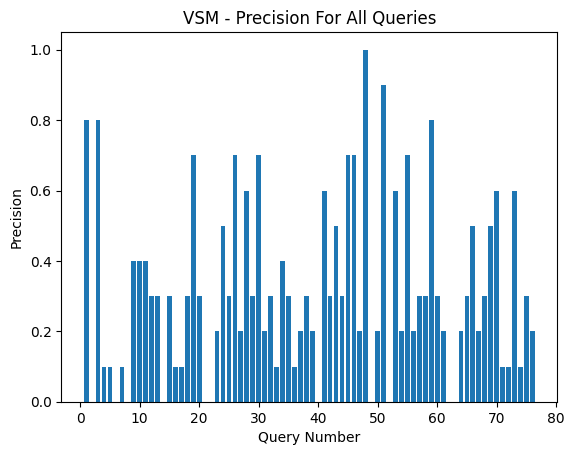

In [289]:
# creating function to plot the precisions of all queries
import matplotlib.pyplot as plt

# Create lists to store query numbers and precisions
query_nums_precision = []
precisions = []

# Calculate precision for each of the first 5 queries
for i, retrieved_doc in enumerate(rel_retrieved_documents[::]):
    # Get the corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # Calculate precision
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set)

    # Append query number and precision to lists
    query_nums_precision.append(i+1)
    precisions.append(precision)

# Create bar chart
plt.bar(query_nums_precision, precisions)
plt.xlabel("Query Number")
plt.ylabel("Precision")
plt.title("VSM - Precision For All Queries")
plt.show()

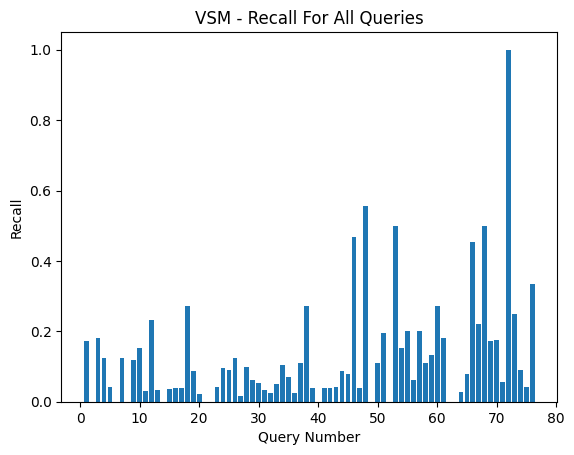

In [290]:
# creating function to plot the recalls of all queries

# Create lists to store query numbers and recalls
query_nums_recall = []
recalls = []

# Calculate recall for each query
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # Get the corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # Calculate true positives and recall
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    recall = true_positives / len(relevant_set)

    # Append query number and recall to lists
    query_nums_recall.append(i+1)
    recalls.append(recall)

# Create bar chart
plt.bar(query_nums_recall, recalls)
plt.xlabel("Query Number")
plt.ylabel("Recall")
plt.title("VSM - Recall For All Queries")
plt.show()


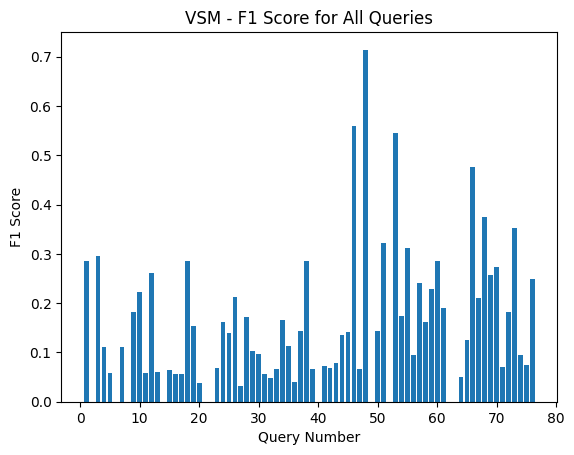

In [291]:
# Create lists to store query numbers and F1 scores
query_nums_f1 = []
f1_scores = []

# Calculate F1 score for each of the first 5 queries
for i, retrieved_doc in enumerate(rel_retrieved_documents[:]):
    # Get the corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # Calculate precision, recall, and F1 score
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set) if len(retrieved_set) > 0 else 0  # add error handling for division by zero
    recall = true_positives / len(relevant_set) if len(relevant_set) > 0 else 0  # add error handling for division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # add error handling for division by zero

    # Append query number and F1 score to lists
    query_nums_f1.append(i+1)
    f1_scores.append(f1_score)

# Create bar chart
plt.bar(query_nums_f1, f1_scores)
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.title("VSM - F1 Score for All Queries")
plt.show()


In [292]:
n = len(precisions)
VSM_map = sum(precisions) / n
print(f"The mean average precision of our Vector Space Model is: {VSM_map}")

The mean average precision of our Vector Space Model is: 0.3171052631578948


In [293]:
MAP_sabs_queries = 0.32763157894736833
MAP_sobs_queries = 0.3171052631578948 # why is this different

**BM25 Evaluation**

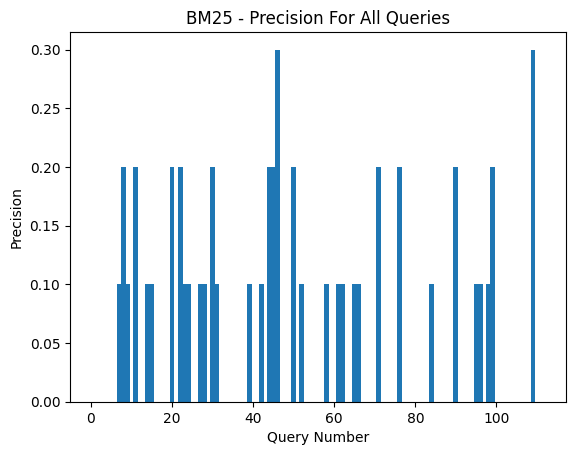

The BM25 Mean Average Precision across all Queries is: 6.7105263157894735 %


In [294]:
# Create lists to store query numbers and precisions
BM25query_nums_precision = []
BM25precisions = []

# Calculate precision for each of the first 5 queries
for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):

    try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        
        # Calculate precision
        BM25retrieved_set = set(BM25_relevant_doc['retrieved_document_ids'])
        BM25relevant_set = set(relevant_doc['relevant_document_ids'])
        BM25true_positives = len(BM25relevant_set.intersection(BM25retrieved_set))
        BM25precision = BM25true_positives / len(BM25retrieved_set)

        # Append query number and precision to lists
        BM25query_nums_precision.append(i+1)
        BM25precisions.append(BM25precision)
    except StopIteration:
        pass  # do nothing, simply move on to the next iteration

# Create bar chart
bar_width = 1.2
plt.bar(BM25query_nums_precision, BM25precisions, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("Precision")
plt.title("BM25 - Precision For All Queries")
plt.show()

print('The BM25 Mean Average Precision across all Queries is:',(sum(BM25precisions)/len(BM25precisions)*100),'%')

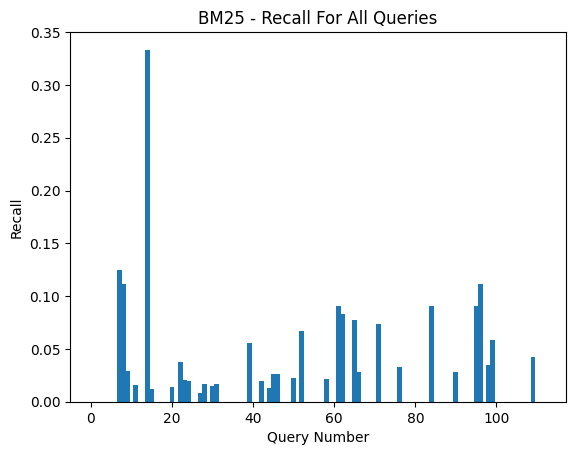

The BM25 Average Recall across all Queries is: 2.461245775032495 %


In [295]:
# Define a function to calculate recall
def calculate_recall(relevant_docs, retrieved_docs):
    retrieved_set = set(retrieved_docs)
    relevant_set = set(relevant_docs)
    true_positives = len(relevant_set.intersection(retrieved_set))
    recall = true_positives / len(relevant_set)
    return recall

# Calculate recall for each of the first 5 queries
BM25query_nums_recall = []
BM25recalls = []

for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):

    try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])

        # Calculate recall
        BM25retrieved_docs = BM25_relevant_doc['retrieved_document_ids']
        BM25relevant_docs = relevant_doc['relevant_document_ids']
        BM25recall = calculate_recall(BM25relevant_docs, BM25retrieved_docs)

        # Append query number and recall to lists
        BM25query_nums_recall.append(i+1)
        BM25recalls.append(BM25recall)
    except StopIteration:
        pass

# Create bar chart for recall
bar_width = 1.2
plt.bar(BM25query_nums_recall, BM25recalls, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("Recall")
plt.title("BM25 - Recall For All Queries")
plt.show()

print('The BM25 Average Recall across all Queries is:',(sum(BM25recalls)/len(BM25recalls)*100),'%')

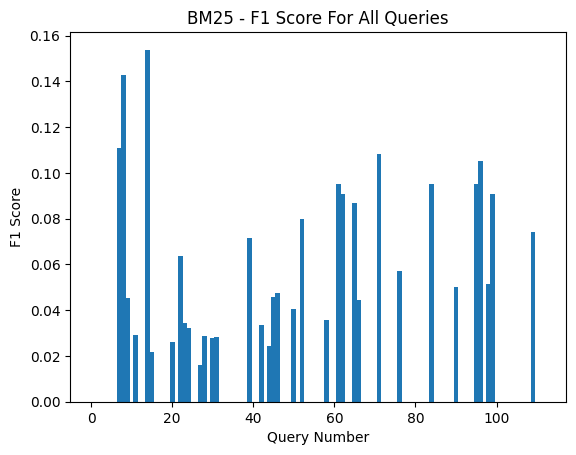

The BM25 Average Recall across all Queries is: 2.874279859850203 %


In [296]:
import matplotlib.pyplot as plt

# Define a function to calculate precision
def calculate_precision(relevant_docs, retrieved_docs):
    # Convert the lists to sets for faster calculations
    relevant_docs_set = set(relevant_docs)
    retrieved_docs_set = set(retrieved_docs)

    # Calculate the intersection of relevant_docs_set and retrieved_docs_set
    intersection = relevant_docs_set.intersection(retrieved_docs_set)

    # Calculate precision
    precision = len(intersection) / len(retrieved_docs)

    return precision

# Define a function to calculate recall
def calculate_recall(relevant_docs, retrieved_docs):
    # Convert the lists to sets for faster calculations
    relevant_docs_set = set(relevant_docs)
    retrieved_docs_set = set(retrieved_docs)

    # Calculate the intersection of relevant_docs_set and retrieved_docs_set
    intersection = relevant_docs_set.intersection(retrieved_docs_set)

    # Calculate recall
    recall = len(intersection) / len(relevant_docs)

    return recall

# Define a function to calculate F1 score
def calculate_f1_score(precision, recall):
    if precision == 0 or recall == 0:
        return 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score

# Calculate F1 score for each of the first 5 queries
BM25query_nums_f1_score = []
BM25f1_scores = []

for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):

    try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])

        # Calculate precision and recall
        BM25retrieved_docs = BM25_relevant_doc['retrieved_document_ids']
        BM25relevant_docs = relevant_doc['relevant_document_ids']
        BM25precision = calculate_precision(BM25relevant_docs, BM25retrieved_docs)
        BM25recall = calculate_recall(BM25relevant_docs, BM25retrieved_docs)

        # Calculate F1 score
        BM25f1_score = calculate_f1_score(BM25precision, BM25recall)

        # Append query number and F1 score to lists
        BM25query_nums_f1_score.append(i+1)
        BM25f1_scores.append(BM25f1_score)
    except StopIteration:
        pass

# Create bar chart for F1 score
bar_width = 1.2
plt.bar(BM25query_nums_f1_score, BM25f1_scores, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.title("BM25 - F1 Score For All Queries")
plt.show()

print('The BM25 Average Recall across all Queries is:',(sum(BM25f1_scores)/len(BM25f1_scores)*100),'%')

In [297]:
n = len(precisions)
BM25_map = sum(BM25precisions) / n
print(f"The mean average precision of our BM25 is: {BM25_map}")

The mean average precision of our BM25 is: 0.06710526315789474


# **Comparative Analysis**

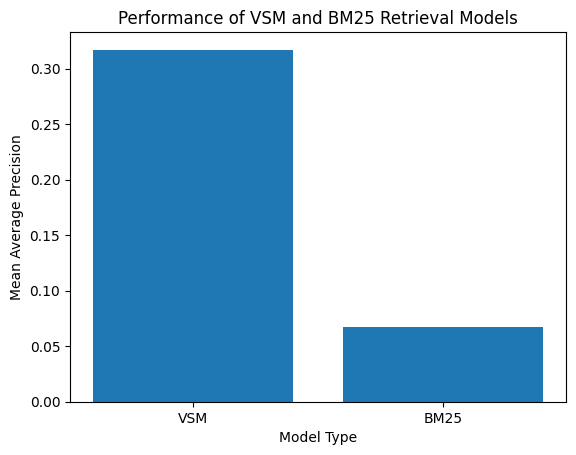

In [298]:
plt.bar(['VSM', 'BM25'], [VSM_map, BM25_map])

# Set the axis labels and title
plt.xlabel('Model Type')
plt.ylabel('Mean Average Precision')
plt.title('Performance of VSM and BM25 Retrieval Models')

# Display the plot
plt.show()

# **Optimisation Steps (if any)**

- fix the F1 function [Done]
- try stemming instead of lemmatization [look into it more?]
- preprocessing needs to be fine-tuned and checked again
- tune the bm25 model's parameters if possible [attempted the model is just shit!]

Grid search Incomplete

In [281]:
import random

# Define the hyperparameter search space
hyperparams = {
    'k1': [1.5, 2.0, 2.5],  
    'k2': [0.2,0.5,1],
    'k3': [6,4,3],
    'b': [0.2, 0.5, 0.7,0.6],
    'term_weights':[0.3,0.5,0.8],
}

# Define a function to evaluate the BM25 implementation with given hyperparameters
def calculate_bm25_score(k1, k2, k3, b, term_weights):
    
    vocabulary = vectorizer.get_feature_names_out()
    df = pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)
    doc_ids = df.index.values
    
    # Calculate DF
    dfs = (df > 0).sum(axis=0)
    
    # Calculate IDFs
    N = len(df)
    idfs = np.log10(N/dfs)
    
    # Calculate average document length
    dls = df.sum(axis=1).tolist()
    avgdl = np.mean(dls)
    
    # Calculate BM25 score
    numerator = np.array((k1 + 1) * df)
    denominator = np.array(k1 * ((1 - b) + b * (dls / avgdl))).reshape(N, 1) + np.array(df)
    BM25_tf = numerator / denominator
    idfs = np.array(idfs)
    BM25_score = (idfs * BM25_tf * term_weights) + ((k2 + 1) * term_weights * df) / ((k2 * (1 - b + b * (dls / avgdl))).reshape(N, 1) + df) + (k3 * term_weights)
    
    # Convert BM25 score to a pandas DataFrame with matching index and column names
    BM25_score = pd.DataFrame(BM25_score, columns=df.columns, index=df.index)

    def calculate_recall(relevant_docs, retrieved_docs):
       retrieved_set = set(retrieved_docs)
       relevant_set = set(relevant_docs)
       true_positives = len(relevant_set.intersection(retrieved_set))
       recall = true_positives / len(relevant_set)
       return recall

    # Calculate recall for each of the first 5 queries
    BM25query_nums_recall = []
    BM25recalls = []

    for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):
      try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])

        # Calculate recall
        BM25retrieved_docs = BM25_relevant_doc['retrieved_document_ids']
        BM25relevant_docs = relevant_doc['relevant_document_ids']
        BM25recall = calculate_recall(BM25relevant_docs, BM25retrieved_docs)

        # Append query number and recall to lists
        BM25query_nums_recall.append(i+1)
        BM25recalls.append(BM25recall)
      except StopIteration:
        pass

        score = sum(BM25recalls)/len(BM25recalls)
        return score  # example random score for demonstration purposes

# Perform random search
num_trials = 100  # number of random trials
best_hyperparams = None
best_score = float('-inf')

for i in range(num_trials):
    # Randomly sample hyperparameter values from the search space
    hyperparams_sample = {param: random.choice(values) for param, values in hyperparams.items()}

    # Evaluate the BM25 implementation with the sampled hyperparameter values
    score = calculate_bm25_score(**hyperparams_sample)

    # Update the best hyperparameters and score if a better score is obtained
    if score > best_score:
        best_hyperparams = hyperparams_sample
        best_score = score

# Print the best hyperparameters and score
print("Best Hyperparameters: ", best_hyperparams)
print("Best Score: ", best_score)


Best Hyperparameters:  {'k1': 2.5, 'k2': 0.5, 'k3': 3, 'b': 0.2, 'term_weights': 0.8}
Best Score:  0.022147695363001818
